Davies-Bouldin Index: 1.4844243664570722
Silhouette Score: 0.196576744685683


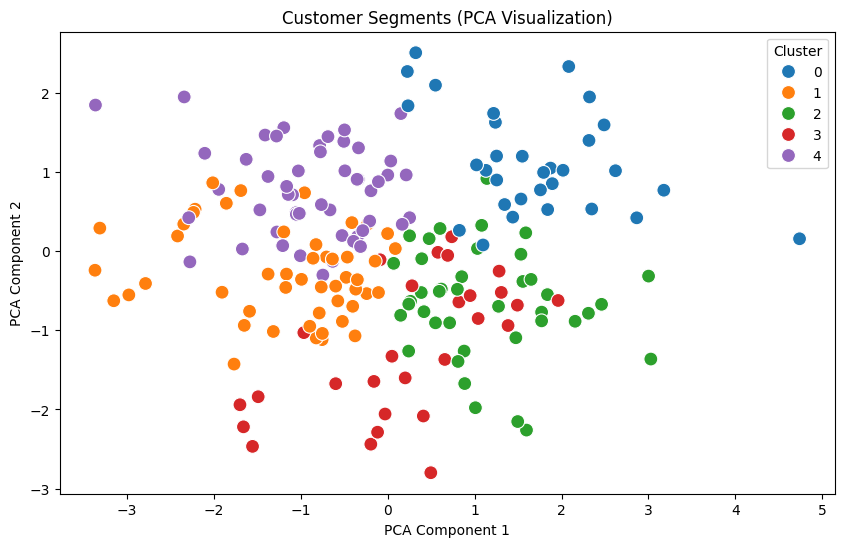

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

data = transactions.merge(customers, on="CustomerID")

customer_features = data.groupby("CustomerID").agg(
    total_spent=pd.NamedAgg(column="TotalValue", aggfunc="sum"),
    avg_transaction_value=pd.NamedAgg(column="TotalValue", aggfunc="mean"),
    transaction_count=pd.NamedAgg(column="TransactionID", aggfunc="count"),
    region=pd.NamedAgg(column="Region", aggfunc="first"),
    signup_date=pd.NamedAgg(column="SignupDate", aggfunc="first")
).reset_index()

customer_features["signup_date"] = pd.to_datetime(customer_features["signup_date"])
customer_features["days_since_signup"] = (pd.Timestamp.now() - customer_features["signup_date"]).dt.days

encoder = OneHotEncoder()
encoded_region = pd.DataFrame(
    encoder.fit_transform(customer_features[["region"]]).toarray(),
    columns=encoder.get_feature_names_out(["region"])
)

numerical_features = customer_features[["total_spent", "avg_transaction_value", "transaction_count", "days_since_signup"]]
scaled_features = StandardScaler().fit_transform(numerical_features)


final_features = pd.concat(
    [pd.DataFrame(scaled_features, columns=numerical_features.columns), encoded_region],
    axis=1
)


kmeans = KMeans(n_clusters=5, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(final_features)


db_index = davies_bouldin_score(final_features, customer_features["Cluster"])
silhouette_avg = silhouette_score(final_features, customer_features["Cluster"])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")


pca = PCA(n_components=2)
pca_features = pca.fit_transform(final_features)
customer_features["PCA1"] = pca_features[:, 0]
customer_features["PCA2"] = pca_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Cluster", data=customer_features, palette="tab10", s=100
)
plt.title("Customer Segments (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


customer_features[["CustomerID", "Cluster"]].to_csv("CustomerClusters.csv", index=False)
